In [1]:
import sys

sys.path.append('../')
from boom.msBO import MultiStateBO
from boom.objective import BPMvar_minimization

import numpy as np
import matplotlib.pyplot as plt
import torch

sys.path.append('../../machineIO/')
from machineIO import construct_machineIO, VirtualMachineIO, StatefulOracleEvaluator

np.random.seed(0)
torch.manual_seed(0)

# import importlib, msBO  # or from boom import msBO if that's your import
# importlib.reload(msBO)

Failed to import 'epics'
Failed to import 'phantasy'


In [2]:
n_init = 2
n_each = 2
beta = 9

In [3]:
n_control = 1
n_bpm = 1
n_monitor = n_bpm*2
n_task = n_bpm+1
n_state = 2
n_state_pvs = 1

control_CSETs = [f'PSC{i}:I_CSET' for i in range(n_control)]
control_RDs  = [f'PSC{i}:I_RD' for i in range(n_control)]
control_tols = [0.01]*len(control_CSETs)
control_min  = [ 0.0]*len(control_CSETs)
control_max  = [ 1.0]*len(control_CSETs)
bpm_xRDs     = [f'BPM{i}:XPOS_RD' for i in range(n_bpm)]
bpm_magRDs   = [f'BPM{i}:MAG_RD' for i in range(n_bpm)]
monitor_RDs  = bpm_xRDs + bpm_magRDs
state_CSETs  = [f'CSS:POS{i}_CSET' for i in range(n_state_pvs)]
state_RDs    = [f'CSS:POS{i}_RD' for i in range(n_state_pvs)]
state_tols   = [0.01]*len(state_CSETs)
state_min    = [0.0]*n_state_pvs
state_max    = [n_state-1]*n_state_pvs
state_key_vals  = {f'state{s}':[float(s)]*n_state_pvs for s in range(n_state)}
oracle_key_names = {'x':control_RDs,
                    'y':bpm_xRDs + ['BPM:MAG_min_ratio']}
states = list(state_key_vals.keys())

In [4]:
# 
# x0 = np.concatenate([x0,state_key_vals['state0']])
vmIO = VirtualMachineIO(
    control_CSETs = control_CSETs + state_CSETs,
    control_RDs = control_RDs + state_RDs,
    monitor_RDs = monitor_RDs,
    control_min = control_min + state_min,
    control_max = control_max + state_max,
    monitor_min = [-5.0]*n_bpm + [0.7]*n_bpm,
    monitor_max = [ 5.0]*n_bpm + [1.0]*n_bpm,
    complexity  = 128,
)



In [5]:
x0 = np.random.rand(len(control_CSETs))*(np.asarray(control_max) - np.asarray(control_min)) + np.asarray(control_min)
print("x0",x0)
BPM_MAGs_ref = {}
for s,v in state_key_vals.items():
    _ = vmIO.ensure_set(vmIO.control_CSETs, vmIO.control_RDs, np.concatenate([x0,v]), control_tols + state_tols)
    y = vmIO.fetch_data(bpm_magRDs).mean().values
    BPM_MAGs_ref[s] = y
BPM_MAGs_ref

x0 [0.78502463]


{'state0': array([0.91010953]), 'state1': array([0.99494134])}

In [6]:
def BPM_MAG_obj(df,s):
    # print('before')
    # print(df.mean())
    df['BPM:MAG_min_ratio'] = (df[bpm_magRDs].values/BPM_MAGs_ref[s][None,:]).min()
    # print('after')
    # print(df.mean())
    return df

In [7]:
oracleEvaluator = StatefulOracleEvaluator(
    vmIO,
    control_CSETs= control_CSETs,
    control_RDs  = control_RDs,
    control_tols = control_tols,
    state_CSETs  = state_CSETs,
    state_RDs    = state_RDs,
    state_tols   = state_tols,
    state_key_vals = state_key_vals,
    oracle_key_names = oracle_key_names,
    monitor_RDs  = monitor_RDs,
    state_df_manipulators = [BPM_MAG_obj],
)

In [8]:
n_grid = 128
x = np.linspace(control_min[0],control_max[0],n_grid)

y = np.zeros((n_state,n_grid,n_task))
for i,s in enumerate(states):
    for j,x_ in enumerate(x):
        o = oracleEvaluator(x=x_,s=s)
        y[i,j] = o['y']       


oracleEvaluator(x=x0,s=states[0])

def plot_ground_truth(fig=None,ax=None):
    if fig is None or ax is None:
        fig,ax = plt.subplots(1,n_task,figsize=(15,3))
    for i,s in enumerate(states):
        for j in range(n_task):
            ax[j].plot(x,y[i,:,j],label=s)
    # for j in range(n_task-1):
    #     ax[j].set_xlabel(control_CSETs[0])
    #     ax[j].set_ylabel(monitor_RDs[j])
        ax[j].set_ylim(-5.5,5.5)        
    j = n_task-1
    # ax[j].set_xlabel(control_CSETs[0])
    # ax[j].set_ylabel(monitor_RDs[j])
    ax[j].set_ylim(0,1.2)   
    fig.tight_layout()     
    return fig,ax

In [9]:
composite_objective_function = BPMvar_minimization(S=n_state, J=n_task)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


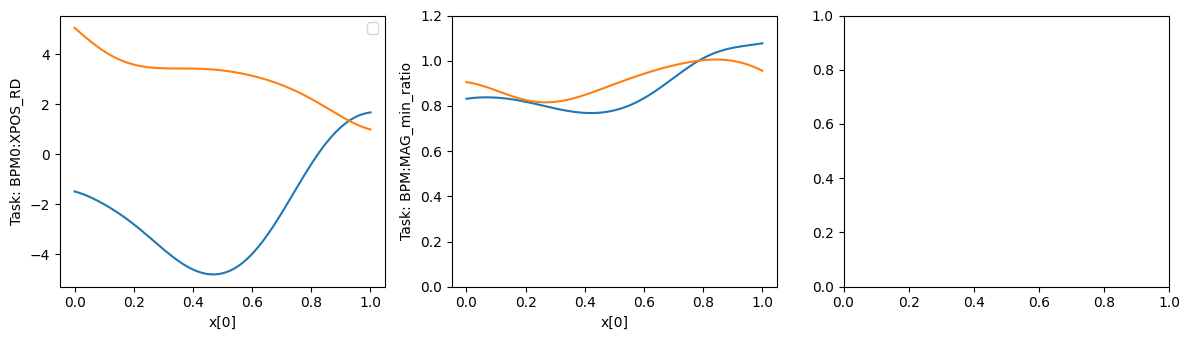

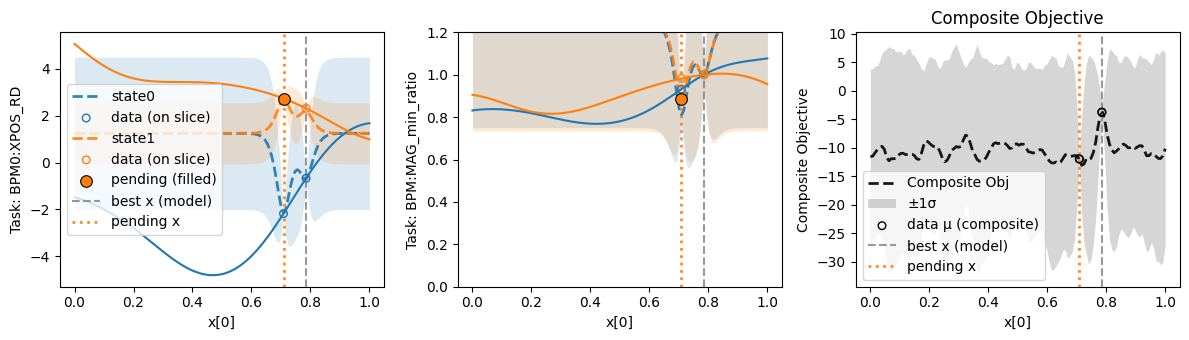

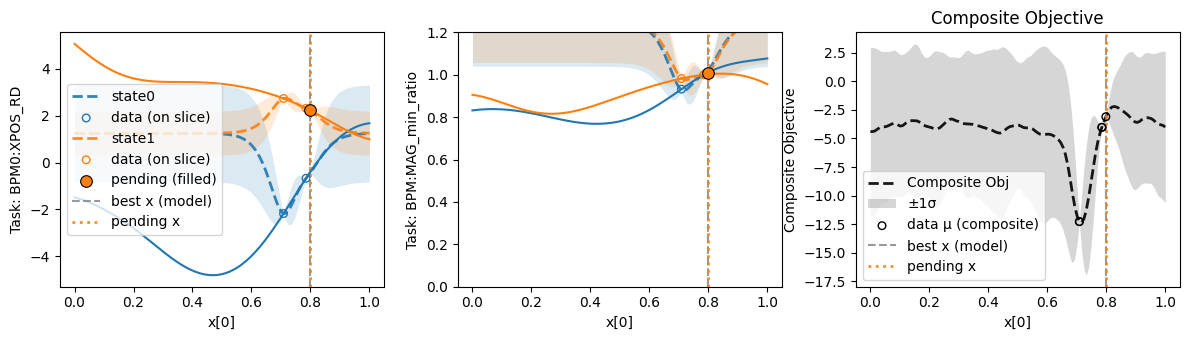

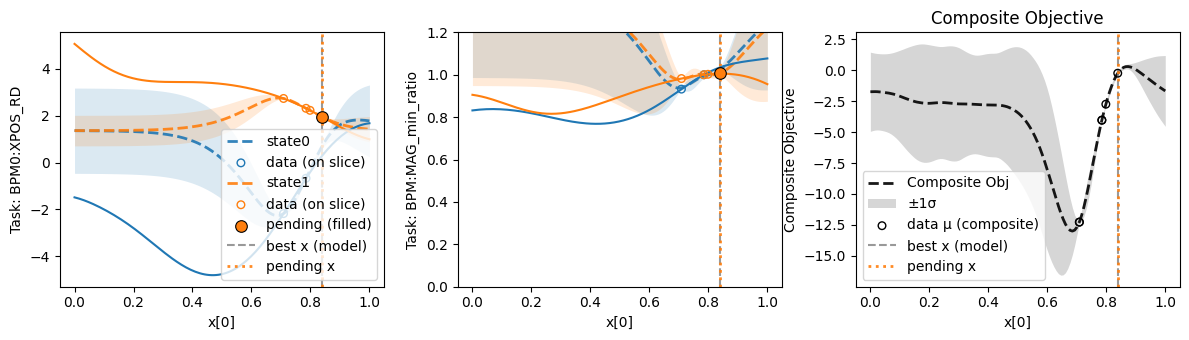

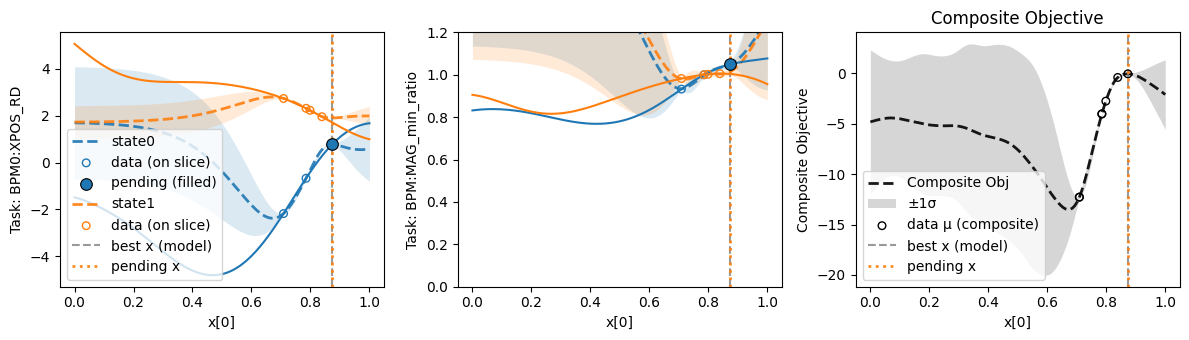

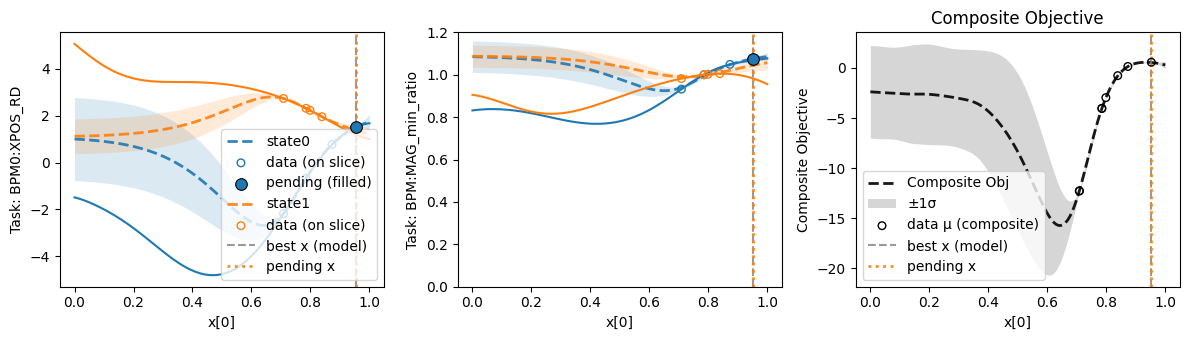

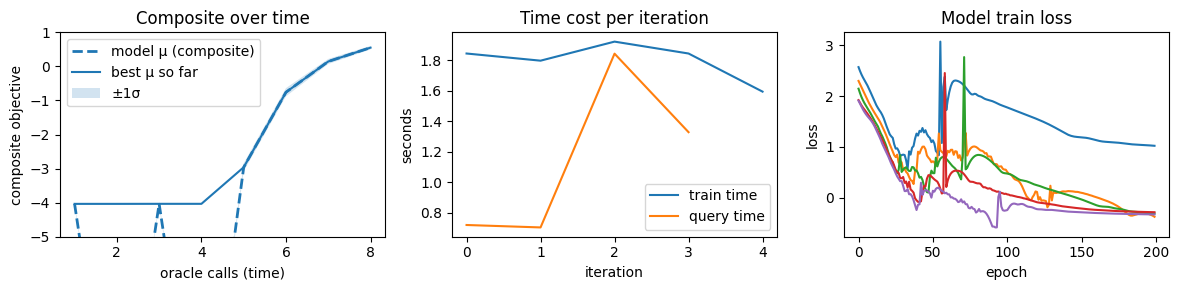

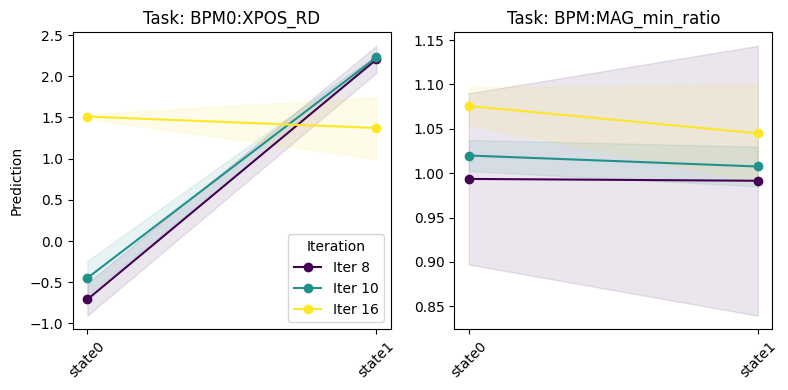

In [16]:
oracleEvaluator(x=x0,s=states[0])
local_optimization = False
acq_type = 'EI'
fix_acq_state = False

msbo = MultiStateBO(
    states = states,
    tasks  = oracle_key_names['y'], 
    control_min = control_min,
    control_max = control_max,
    multistate_oracle_evaluator = oracleEvaluator,
    composite_objective_function = composite_objective_function,
    local_bound_size = 0.2*(np.asarray(control_max) - np.asarray(control_min))
    )

fig,ax = msbo.plot_tasks_1d()
plot_ground_truth(fig,ax)
msbo.init(n_init=n_init, local_optimization=local_optimization)
fig,ax = msbo.plot_tasks_1d()
plot_ground_truth(fig,ax)
plt.show()
for s in states[::-1]:
    for i in range(n_each):
        msbo.step(s=s, local_optimization=local_optimization, acq_type=acq_type, fix_acq_state=fix_acq_state)
        fig,ax = msbo.plot_tasks_1d()
        plot_ground_truth(fig,ax)
        plt.show()
fig,ax,virtualObjMean = msbo.plot_composite_objective()
ax[0].set_ylim(-5,1)

snapshot_iters = np.arange(len(msbo.dataset._x))
fig, axes = msbo.plot_state_predictions_history(iterations=snapshot_iters)
plt.show()

In [ ]:
msbo.da

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


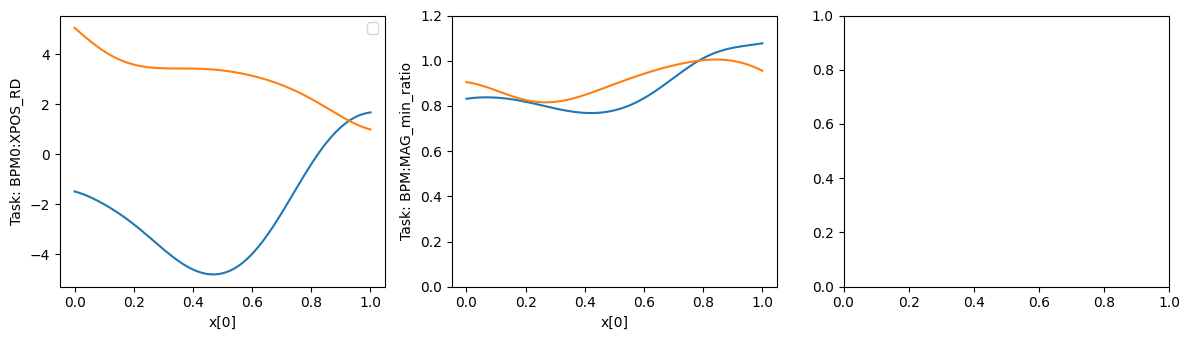

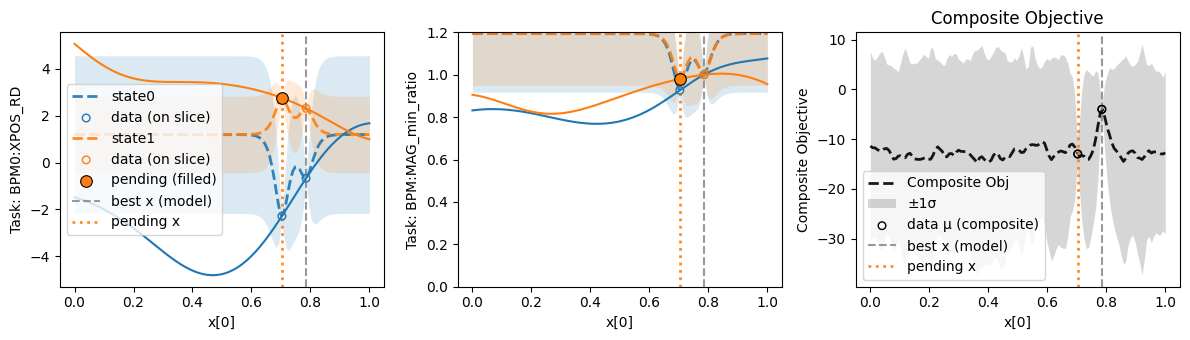

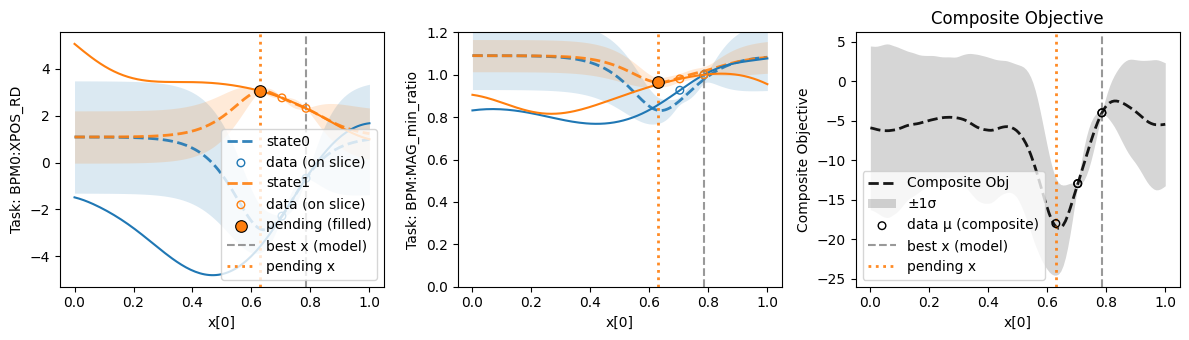

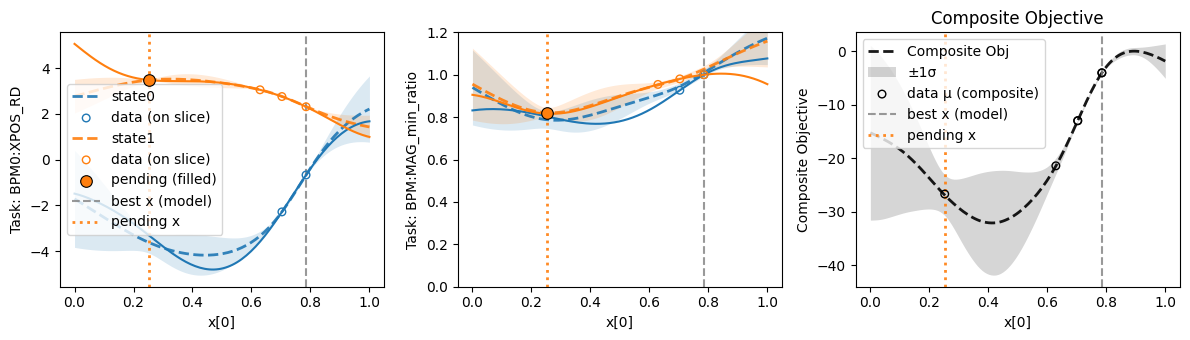

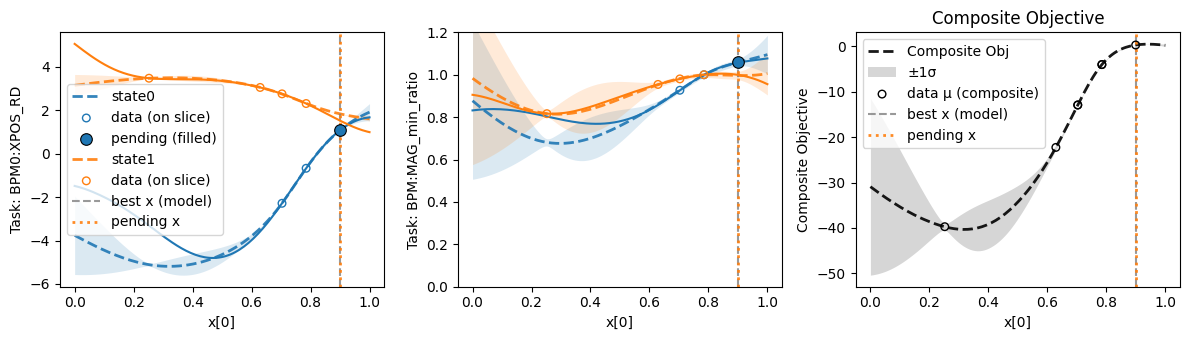

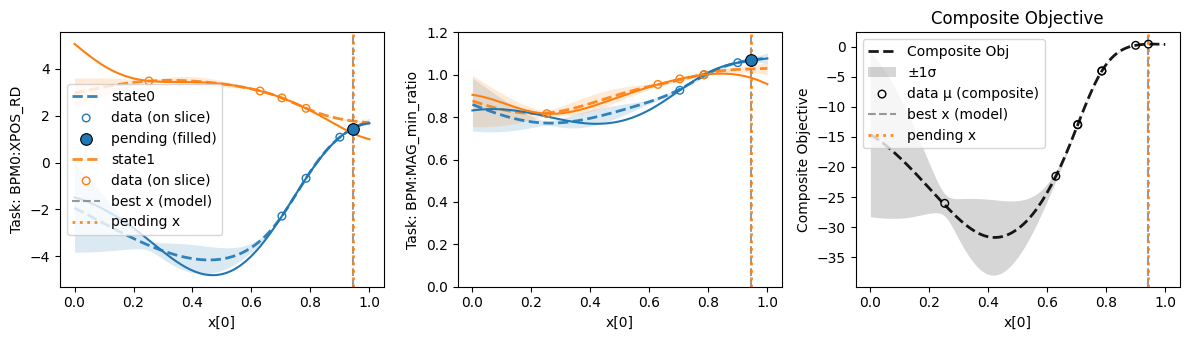

(-5.0, 1.0)

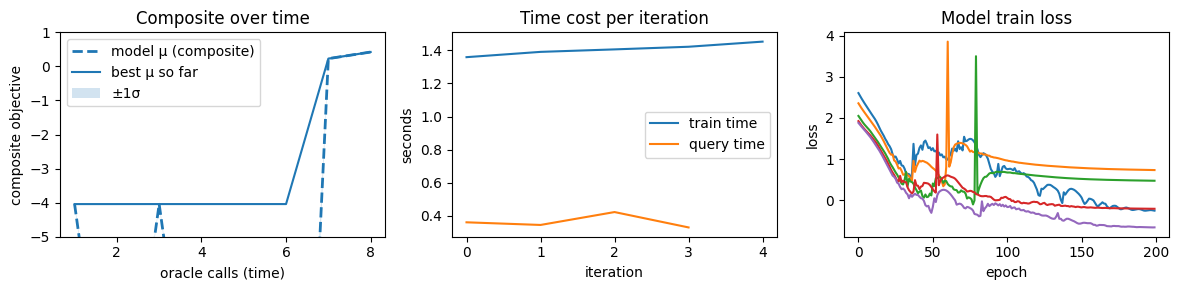

In [11]:
oracleEvaluator(x=x0,s=states[0])
local_optimization = False
acq_type = 'EI'
fix_acq_state = True

np.random.seed(0)
torch.manual_seed(0)

msbo = MultiStateBO(
    states = states,
    tasks  = oracle_key_names['y'], 
    control_min = control_min,
    control_max = control_max,
    multistate_oracle_evaluator = oracleEvaluator,
    composite_objective_function = composite_objective_function,
    local_bound_size = 0.2*(np.asarray(control_max) - np.asarray(control_min))
    )

fig,ax = msbo.plot_tasks_1d()
plot_ground_truth(fig,ax)
msbo.init(n_init=n_init, local_optimization=local_optimization)
fig,ax = msbo.plot_tasks_1d()
plot_ground_truth(fig,ax)
plt.show()
for s in states[::-1]:
    for i in range(n_each):
        msbo.step(s=s, local_optimization=local_optimization, acq_type=acq_type, fix_acq_state=fix_acq_state)
        fig,ax = msbo.plot_tasks_1d()
        plot_ground_truth(fig,ax)
        plt.show()
fig,ax,vobj_mean = msbo.plot_composite_objective()
ax[0].set_ylim(-5,1)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


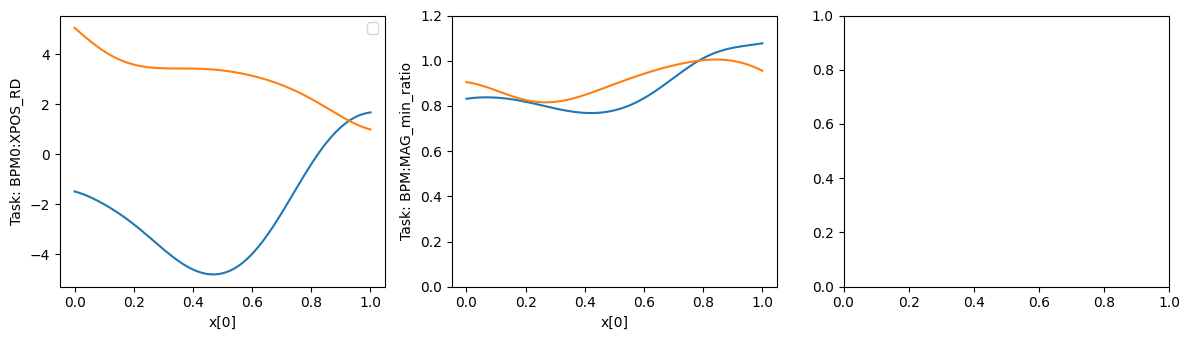

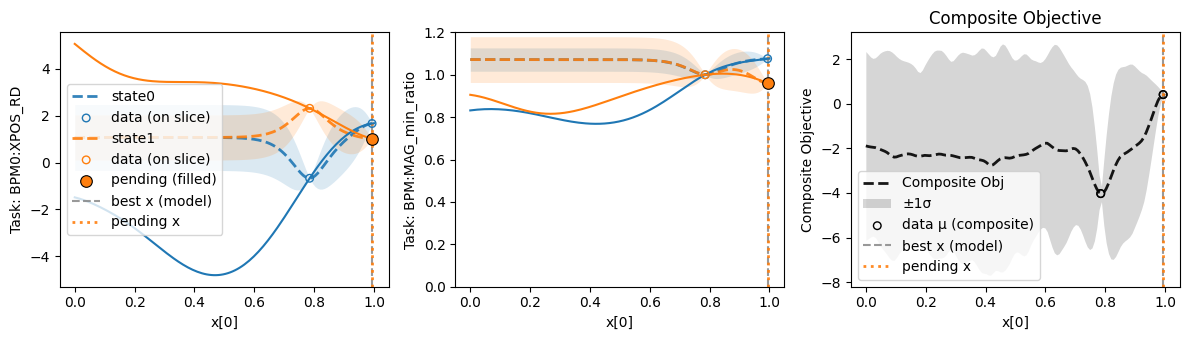

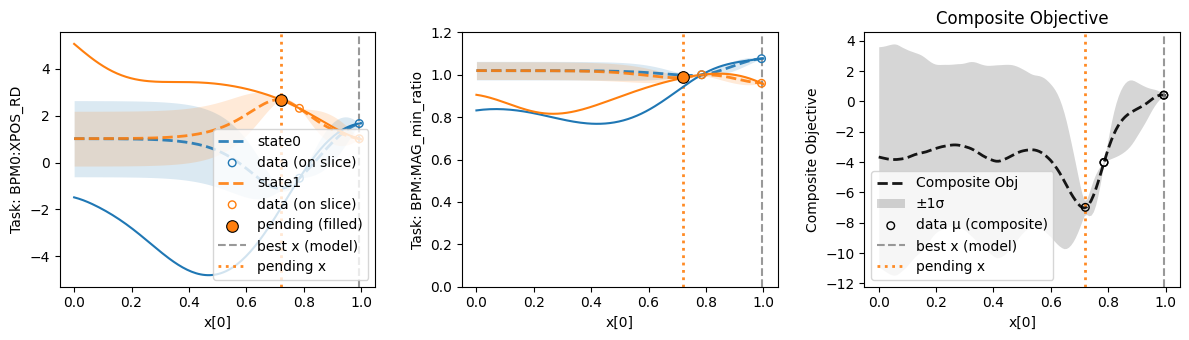

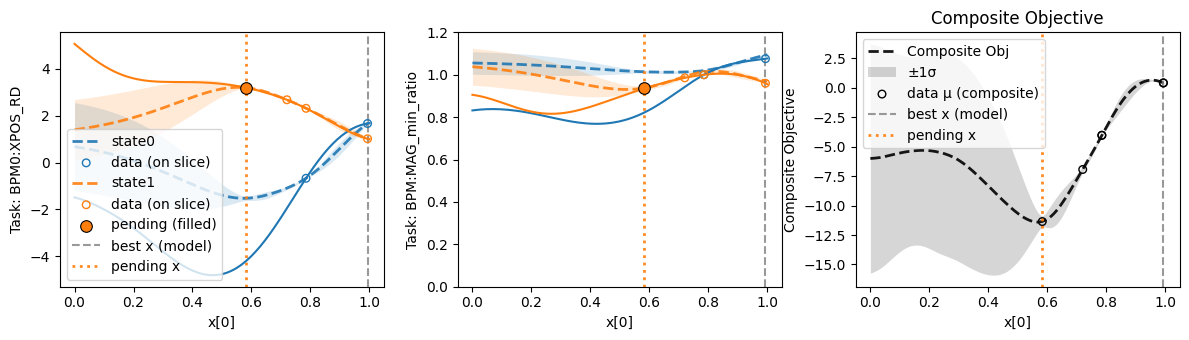

C:\Users\HWANG\AppData\Local\Programs\Python\Python311\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


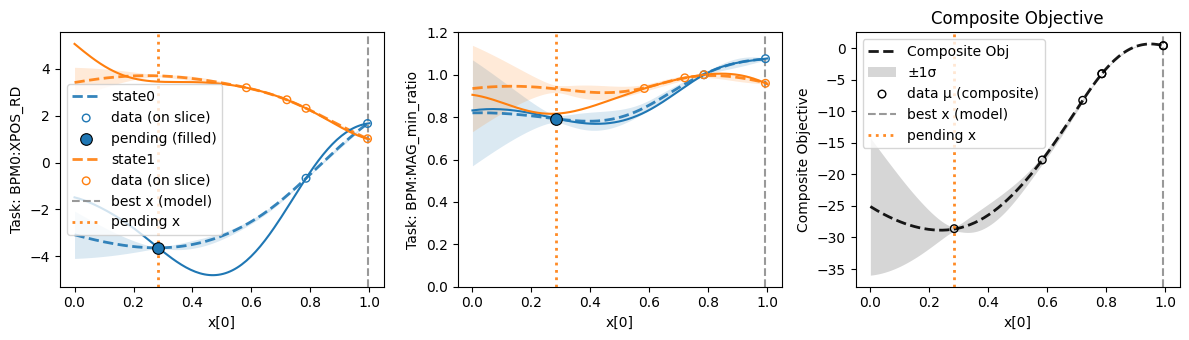

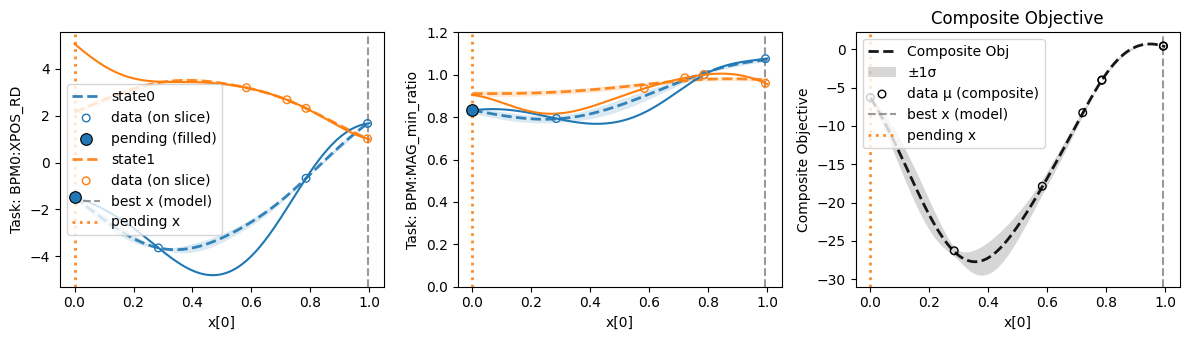

(-5.0, 1.0)

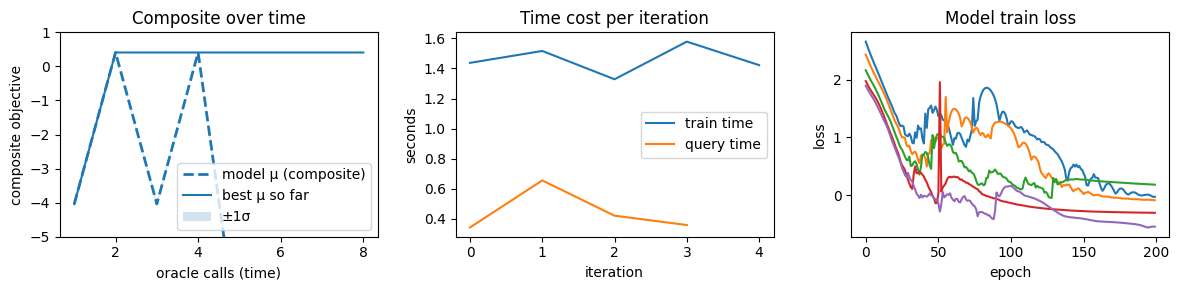

In [12]:
oracleEvaluator(x=x0,s=states[0])
local_optimization = False
acq_type = 'UCB'
fix_acq_state = False

np.random.seed(0)
torch.manual_seed(0)

msbo = MultiStateBO(
    states = states,
    tasks  = oracle_key_names['y'], 
    control_min = control_min,
    control_max = control_max,
    multistate_oracle_evaluator = oracleEvaluator,
    composite_objective_function = composite_objective_function,
    local_bound_size = 0.2*(np.asarray(control_max) - np.asarray(control_min))
    )

fig,ax = msbo.plot_tasks_1d()
plot_ground_truth(fig,ax)
msbo.init(n_init=n_init, local_optimization=local_optimization)
fig,ax = msbo.plot_tasks_1d()
plot_ground_truth(fig,ax)
plt.show()
for s in states[::-1]:
    for i in range(n_each):
        msbo.step(s=s, local_optimization=local_optimization, acq_type=acq_type, fix_acq_state=fix_acq_state, beta=beta)
        fig,ax = msbo.plot_tasks_1d()
        plot_ground_truth(fig,ax)
        plt.show()
fig,ax,vobj_mean = msbo.plot_composite_objective()
ax[0].set_ylim(-5,1)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


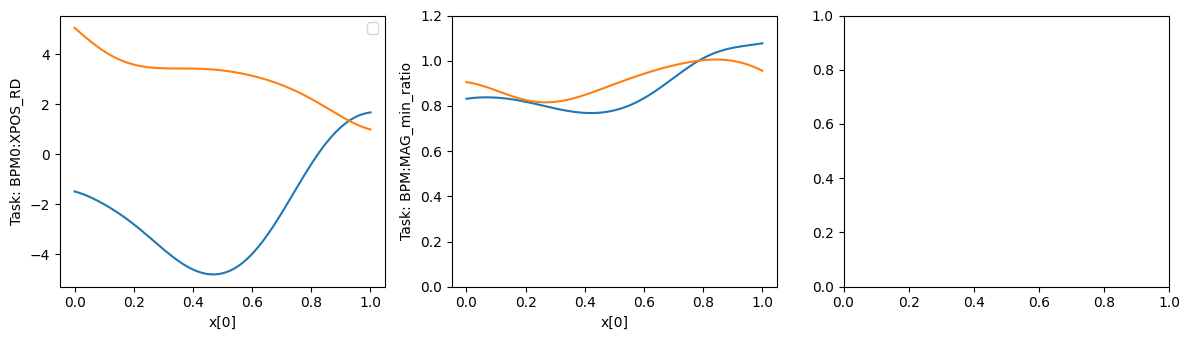

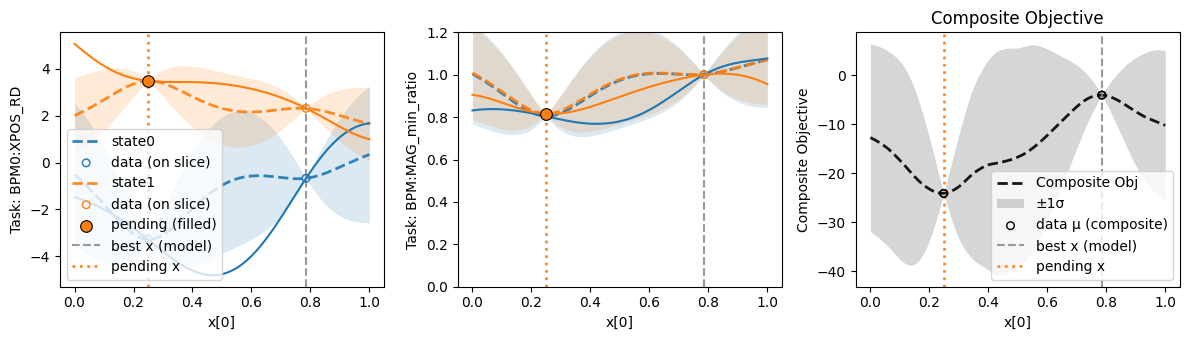

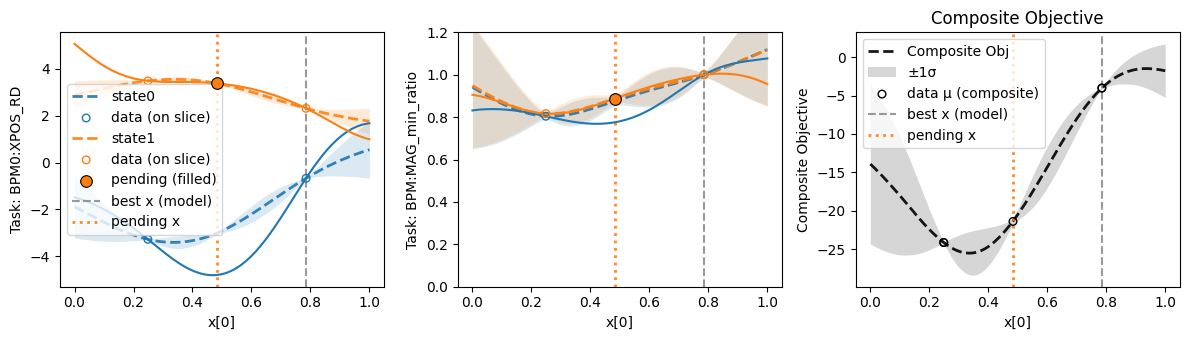

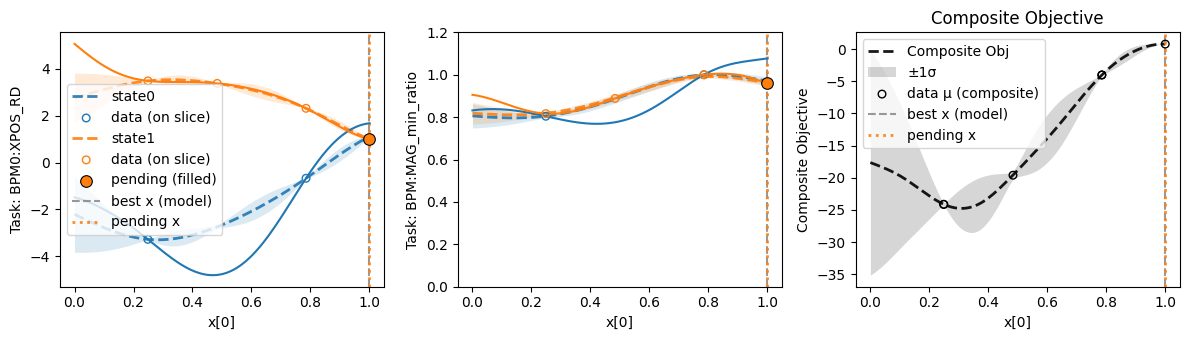

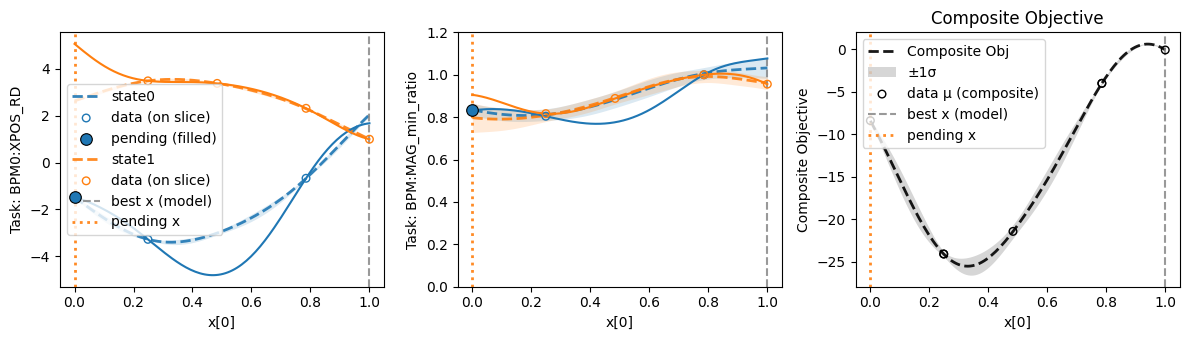

C:\Users\HWANG\AppData\Local\Programs\Python\Python311\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


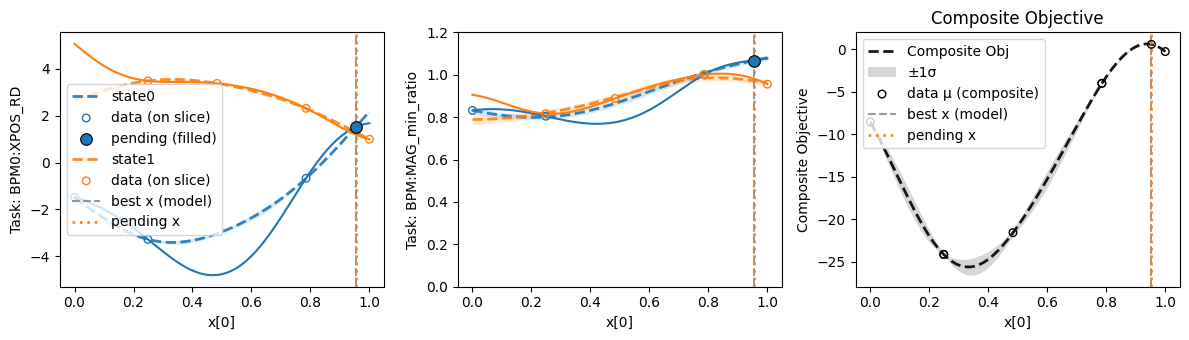

(-5.0, 1.0)

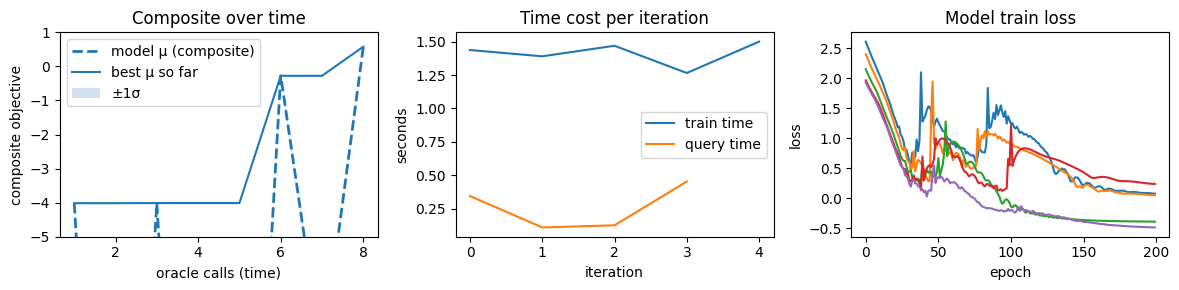

In [13]:
oracleEvaluator(x=x0,s=states[0])
local_optimization = False
acq_type = 'UCB'
fix_acq_state = True

np.random.seed(0)
torch.manual_seed(0)

msbo = MultiStateBO(
    states = states,
    tasks  = oracle_key_names['y'], 
    control_min = control_min,
    control_max = control_max,
    multistate_oracle_evaluator = oracleEvaluator,
    composite_objective_function = composite_objective_function,
    local_bound_size = 0.2*(np.asarray(control_max) - np.asarray(control_min))
    )

fig,ax = msbo.plot_tasks_1d()
plot_ground_truth(fig,ax)
msbo.init(n_init=n_init, local_optimization=local_optimization)
fig,ax = msbo.plot_tasks_1d()
plot_ground_truth(fig,ax)
plt.show()
for s in states[::-1]:
    for i in range(n_each):
        msbo.step(s=s, local_optimization=local_optimization, acq_type=acq_type, fix_acq_state=fix_acq_state, beta=beta)
        fig,ax = msbo.plot_tasks_1d()
        plot_ground_truth(fig,ax)
        plt.show()
fig,ax,vobj_mean = msbo.plot_composite_objective()
ax[0].set_ylim(-5,1)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


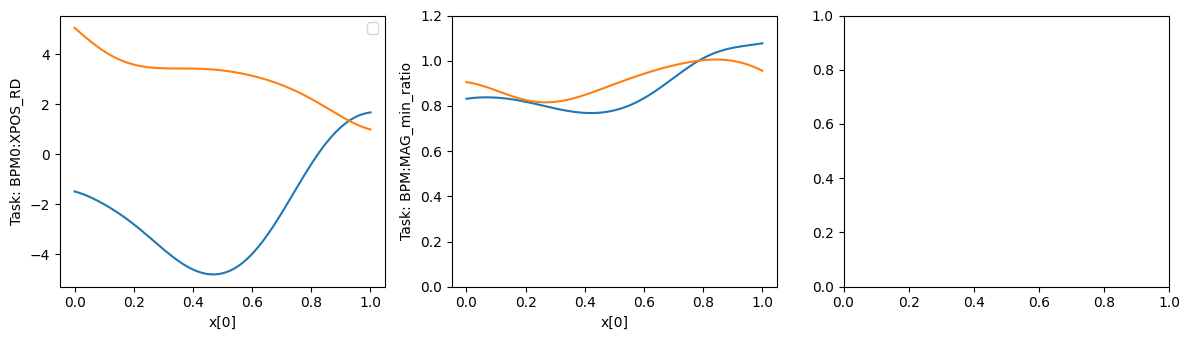

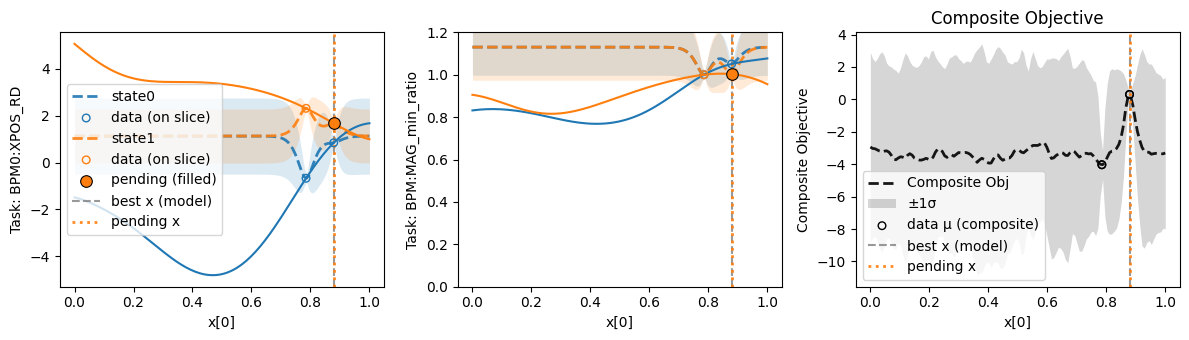

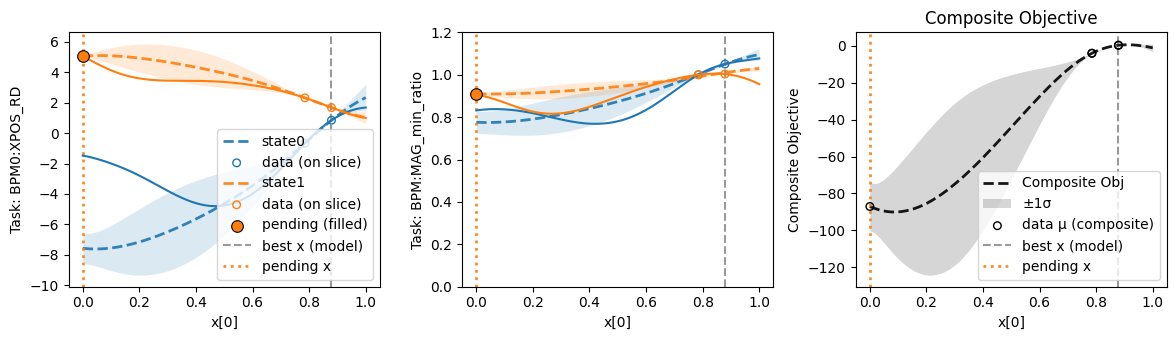

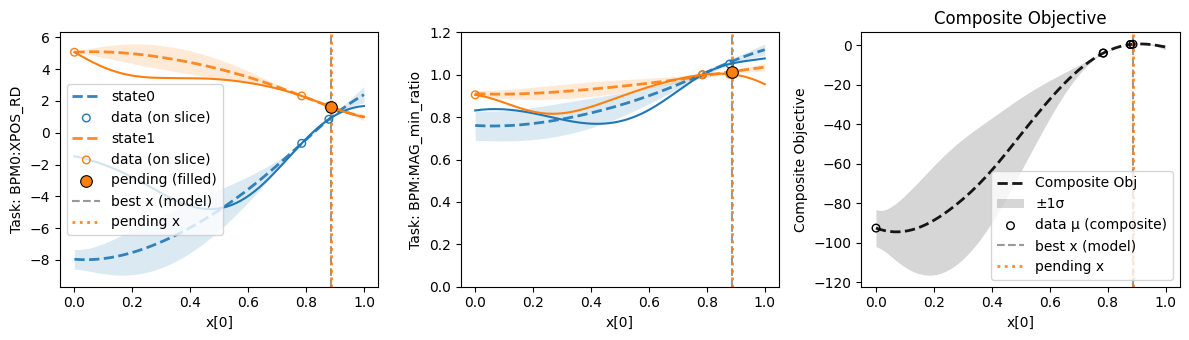

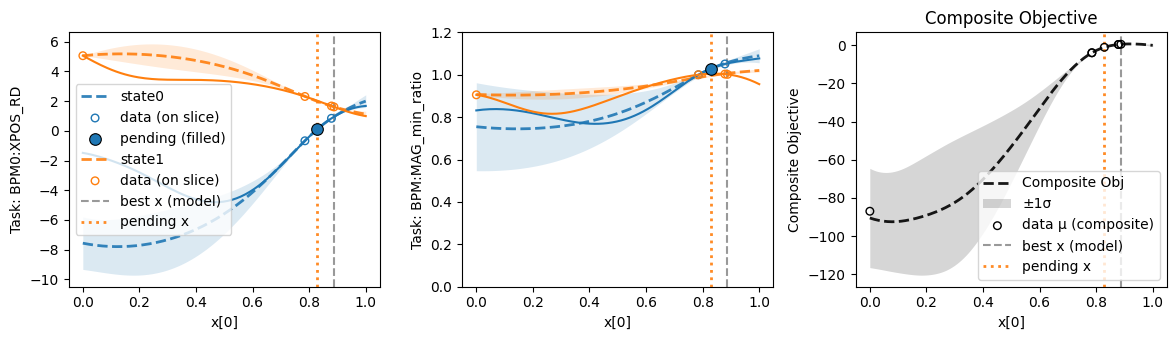

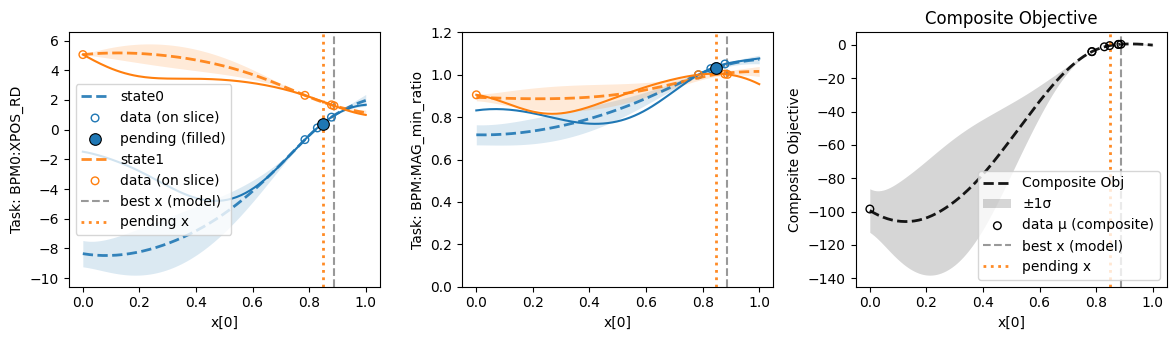

(-5.0, 1.0)

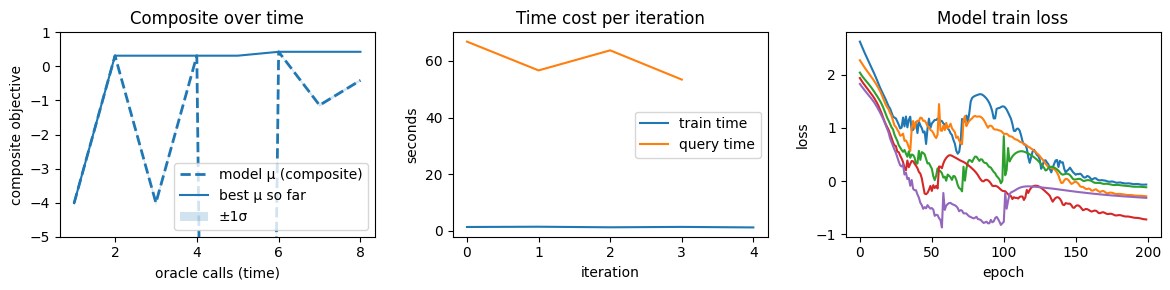

In [14]:
oracleEvaluator(x=x0,s=states[0])
local_optimization = False
acq_type = 'KG'
fix_acq_state = True

np.random.seed(0)
torch.manual_seed(0)

msbo = MultiStateBO(
    states = states,
    tasks  = oracle_key_names['y'], 
    control_min = control_min,
    control_max = control_max,
    multistate_oracle_evaluator = oracleEvaluator,
    composite_objective_function = composite_objective_function,
    local_bound_size = 0.2*(np.asarray(control_max) - np.asarray(control_min))
    )

fig,ax = msbo.plot_tasks_1d()
plot_ground_truth(fig,ax)
msbo.init(n_init=n_init, local_optimization=local_optimization)
fig,ax = msbo.plot_tasks_1d()
plot_ground_truth(fig,ax)
plt.show()
for s in states[::-1]:
    for i in range(n_each):
        msbo.step(s=s, local_optimization=local_optimization, acq_type=acq_type, fix_acq_state=fix_acq_state)
        fig,ax = msbo.plot_tasks_1d()
        plot_ground_truth(fig,ax)
        plt.show()
fig,ax,vobj_mean = msbo.plot_composite_objective()
ax[0].set_ylim(-5,1)